#  ATOC5860 Application Lab #6 - supervised_ML
##### Written by Dr. Middlemas (formerly CU, now PricewaterhouseCoopers) with commenting from Prof. Kay (CU)
##### last updated April 18, 2023 - works with environment - environment.yml

### LEARNING GOALS:
1.	Build familiarity with the data processing pipeline (workflow) required to utilize supervised machine learning techniques.
2.	Implement and compare four different supervised learning algorithms 
3.	Understanding two outcomes of supervised learning algorithms: prediction and feature importance.
4.	Start building a foundation for future machine learning including the following terms: cross-validation, training vs. testing data, metrics (accuracy, recall, precision, f1 score, etc.), overfitting/underfitting, balancing datasets, hyperparameters, & feature importance.  Some future learning resources are provided… but there’s a lot available!  Share resources you find valuable.

### DATA and UNDERLYING SCIENCE MOTIVATION:  

We will use the Christman dataset which contains weather observations from Fort Collins, Colorado for the year 2016. We will build and train four machine learning models to predict something we already know from the dataset: Is it raining?. The point is not to conduct cutting-edge research or make novel predictions. Instead, the purpose here is to showcase supervised machine learning (ML) models and methods. By the end, we hope you can walk away with more confidence to learn and apply these tools to new problems.

Let's say you want to determine which features or atmospheric variables are the best predictors of rainfall. Often, one simply regresses some metric of precipitation onto various atmospheric variables. Then, you assume that whatever returns the highest regression coefficient is the best predictor. While this approach with linear regression presents a fine first guess, it poses a few problems. Linear regression assumes: 1) atmospheric variables are linearly related to precipitation, 2) atmospheric variables are uncorrelated. Yet, both are false assumptions. While a linear relationship between predictor & predictand is a good first guess, why limit yourself to linearity when you can just as easily relax that assumption using supervised Machine Learning... 

This notebook will step through the following Machine Learning model pipeline:

In this notebook, we will use supervised machine learning to **predict the likelihood of rainfall given certain atmospheric conditions**.  After prepping the data, we will build and train four supervised machine learning models to make the predictions: Logistic regression, Random Forest, Singular vector machines/classifier, Neural Network. Finally, we will determine which variable ("feature") is the best predictor of rainfall, i.e., we will assess "feature importance".

Pros/Cons of the supervised machine learning models implemented here:
1.	Logistic regression tends to overgeneralize or underfit data, but is easy to implement, to understand and easy to back out feature importance.
2.	Singular Vector Machines are great at capturing complex relationships, but cannot back out feature importance. Plus, the use of the kernel makes them hard to interpret.
3.	Random forests are easier to understand, generally do not overfit, and can capture complex relationships, and can provide feature importance, but they can be slow to train and there are a lot of hyperparameters to choose from.
4.	Neural Networks are great at capturing complex relationships. But they are slow to train and are susceptible to overfitting.

**Questions to guide your analysis** 

1) Which machine learning model performs the best to predict rainfall?  What metrics did you use to make this assessment?
  - The metrics that we use to evaluate the different methods are Accuracy, Recall and Precision. To calculate these metrics, we need to know the true/false positive/negative rates.  

2) Describe the difference between accuracy and recall.  Why did we choose to use accuracy, recall, and predicted precipitation probability as a way to compare models?  In forecasting: when is a false positive (you said it would rain, it didn’t rain) preferred over a false negative (you said it wouldn’t rain, it did rain)? 
  - Accuracy is the proportion of both rain/no rain events that were correctly predicted, and recall is the proportion of just the raining hours that were correctly predicted. In this case, we may not care as much about correctly predicting when it will not rain, so recall may be more appropriate. 

3) One important "gotcha" in a machine learning workflow or pipeline is the order of data preparation. Why should one should perform the train-test split before feature scaling and rebalancing? Hint: think about using a trained model for future predictions. Do you want your scaling of the testing data to depend on the training data? Why perform a test-train split at all? 
  - A test-train split is important becuase we need to validate our model using data that it has not seen before. You do not want the scaling of the testing data to depend on the training data becuase you want your two samples to be as independent as possible. 

4) Collinearity, or non-zero correlation among features, results in a model that is overly complex, reduces the statistical significance of the fit of the model, and prevents one from correctly identifying the importance of features. Are there features included in our machine learning models to predict rain in the Christman dataset that are collinear? If so, how do you think we should address this collinearity? A couple of suggestions: If we don't have that many features, we could use our meteorological expertise to simply remove one of the features that shares collinearity with other features. Another way to address collinearity is to use feature regularization, or add weights that penalize features that add noise, ultimately reducing model complexity.
  - Yes, there are variables in this dataset that are collinear. For example, temperature and dewpoint temperature are highly correlated, as are wind gust and wind speed. We could simplify the model by selecting just one of these variables. 

In [2]:
import pandas as pd
import numpy as np
import datetime
import time

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## STEP 1: Read in the Data into a pandas dataframe and Look At It

In [5]:
# read in the data
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/christman_2016.csv")
# preview data (also through df.head() & df.tail())
df

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,Prec_inches
0,42370,0.000000,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0.0
1,42370,0.041667,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0.0
2,42370,0.083333,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0.0
3,42370,0.125000,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0.0
4,42370,0.166667,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8779,42735,0.791667,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0,0.0
8780,42735,0.833333,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1,0.0
8781,42735,0.875000,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1,0.0
8782,42735,0.916667,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1,0.0


In [6]:
df.corr()

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,Prec_inches
day,1.000000e+00,-2.203312e-15,0.138793,-0.071413,0.108642,-0.096108,-0.050183,-0.079650,-0.059628,0.109155,-0.035683,-0.035119
hour,-2.203312e-15,1.000000e+00,0.212004,-0.266057,0.039716,0.149273,-0.052187,0.160089,-0.092326,-0.036269,0.083626,0.014125
temp_F,1.387932e-01,2.120043e-01,1.000000,-0.574153,0.719704,0.162699,-0.167712,0.202120,-0.194735,0.021894,0.478878,-0.024359
RH,-7.141286e-02,-2.660574e-01,-0.574153,1.000000,0.122254,-0.373648,0.104435,-0.427262,0.097726,0.071043,-0.517120,0.133400
dewtemp_F,1.086415e-01,3.971598e-02,0.719704,0.122254,1.000000,-0.128574,-0.114743,-0.124749,-0.148474,0.100892,0.121729,0.063666
wind_mph,-9.610770e-02,1.492733e-01,0.162699,-0.373648,-0.128574,1.000000,0.186733,0.937955,0.189608,-0.263157,0.198731,0.063152
wind_dir,-5.018307e-02,-5.218744e-02,-0.167712,0.104435,-0.114743,0.186733,1.000000,0.146122,0.500626,-0.052449,-0.285403,0.039348
windgust,-7.964987e-02,1.600889e-01,0.202120,-0.427262,-0.124749,0.937955,0.146122,1.000000,0.151925,-0.304600,0.206826,0.072187
windgust_dir,-5.962837e-02,-9.232583e-02,-0.194735,0.097726,-0.148474,0.189608,0.500626,0.151925,1.000000,-0.054304,-0.304850,0.020689
pres_Hg,1.091553e-01,-3.626872e-02,0.021894,0.071043,0.100892,-0.263157,-0.052449,-0.304600,-0.054304,1.000000,0.045774,-0.041725


In [ ]:
df.day.nunique() ## Print the answer to: How many days are in this dataset?

366

In [ ]:
##Optional: transform the day column into a readable date. Run this ONCE.
df['day'] = [datetime.date.fromordinal(day+693594) for day in df['day']]

## STEP 2: Data and Function Preparation

Data preparation is a huge part of building Machine Learning model "pipelines". Carefully think through building & training a Machine Learning model before you run it. There are a few statistical "gotchas" that may result in your model being biased, inaccurate, or not suitable for the problem at hand.  Address these 6 questions!

**Q1: What exactly are we trying to predict? A value, an outcome, a category?** Define your predictors and predictand. Relate these to your hypothesis or overarching question. In our case, our predictand is the likelihood of precipitation. We will build models to predict the likelihood that it's currently precipitating, given current atmospheric conditions.

**Q2: Do you have any missing data? If so, how will you handle them?** Keep in mind, decreasing the number of input observations may bias your model. Using the Christman dataset, we have no missing data.

**Q3: Do you have any categorical or non-numeric variables or features?** If so, you must figure out how to encode them into numbers. Luckily, in the geosciences, we rarely run into this problem.

**Q4: How will we validate our model?** Typically, people split their existing data into training data and testing data, or perform "cross-validation" or a "test-train split". That is, we will "hold out" some data and call it our "testing data", while using the rest of the data to train our model (i.e., "training data"). Once our model is trained, we will evaluate its performance with the holdout testing data. Note: This could be problematic if there is limited data.

**Q5: Do your features have the same variance?** You need to consider this to ensure your model doesn't overly depend on one variable with large variance. This step is called "feature scaling". Features of the same size also speed up the Gradient Descent algorithm.

**Q6: If classification is the goal, are there the same number of observations for each feature and outcome? If not, how will you rebalance?** Here, the Christman dataset has same number of observations (8784) for each feature. But, times with no precipitation are way more common than times with precipitation. To deal with this issue, we will oversample the observations associated with precip so that the two outcomes (or "classes") are equal. Note: It's important that feature scaling or normalization is performed before any rebalancing so that the qualitative statistics (mean, stddev, etc) remain the same.

**Q7: Which metrics are appropriate for assessing your model?** Consider the bias-variance trade-off, and whether having false positives or false negatives is more impactful. In our case, predicting no rain when there is rain (false negative) is probably more frustrating and potentially more impactful than the other way around (a false positive).

**Q1. What exactly are you trying to predict?**

First, split data into predictor & predictands. 

In [ ]:
##Create a new feature that indicates whether precipitation occurred. Perform this step ONCE.
#print(df.columns) # print if you need to see what is the variable called that indicates precipitation amount?
df['prec_occur'] = np.array(df.Prec_inches!=0).astype(int)

In [ ]:
#Next, select the data that will be predictors.
predictors = df.copy(deep=True)  # here, we use "deep = True" so that changes to predictors won't be made to the df.

#Next, we drop some variables that shouldn't be used to predict whether or not there is rain.
predictors = df.drop(['day','hour','Prec_inches'],axis=1) 
predictors

,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,prec_occur
0,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0
1,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0
2,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0
3,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0
4,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0
...,...,...,...,...,...,...,...,...,...,...
8779,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0,0
8780,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1,0
8781,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1,0
8782,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1,0


In [ ]:

## Great, that worked. Now I will assign everything but "prec" to be the predictor array "x", 
## and prec will be the predictand vector "y".

x = predictors.drop('prec_occur',axis=1)
y = predictors.prec_occur

**Q2 & Q3 do not need to be addressed in our dataset.**

**Q4. How will you validate your model?**

We will perform a test-train split to validate our trained model. This step must be performed before each time the model is trained to ensure we are not baking in any bias among the models we train. That also means the following two steps must also be performed prior to training each model as well. For this reason, we write functions to call 
easily before each model training.

In [ ]:

from sklearn.model_selection import train_test_split
from random import randint

In [ ]:
def define_holdout_data(x, y, verbose):
    """Perform a 80/20 test-train split (80% of data is training, 20% is testing). Split is randomized with each call."""
    random_state = randint(0,1000)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)
    if verbose==True:
        print("Prior to scaling and rebalacing...")
        print("Shape of training predictors: "+str(np.shape(x_train)))
        print("Shape of testing predictors: "+str(np.shape(x_test)))
        print("Shape of training predictands: "+str(np.shape(y_train)))
        print("Shape of testing predictands: "+str(np.shape(y_test)))
        print(" ")
    return x_train, x_test, y_train, y_test

**Q5. Do your features have the same variance?**

We must normalize the features. In machine learning this is called Feature Scaling". We do this so that the features with the largest variance are note weighted more heavily than those with less variance. Note: If our predictand wasn't binary, then we would normalize it as well.

We'll keep the data as a pandas dataframe rather than converting it to a numpy array beforehand. The "fit_transform" function outputs a numpy array, but we will convert back to a dataframe so that re-balancing the dataset is easier.

In [ ]:
from sklearn import preprocessing

In [ ]:
def scale_data(x_train, x_test):
    """
    Scale training data so that model reaches optimized weights much faster. 
    
    *All data that enters the model should use the same scaling used to scale the training data.*
    Thus, we also perform scaling on testing data for validation later. 
    Additionally, we return the scaler used to scale any other future input data.
    """
    
    scaler = preprocessing.MinMaxScaler() # normalize 
    x_train_scaled = pd.DataFrame(data=scaler.fit_transform(x_train),index=x_train.index,columns=x_train.columns) 
    x_test_scaled = pd.DataFrame(data=scaler.transform(x_test),index=x_test.index,columns=x_test.columns)
    
    return scaler, x_train_scaled, x_test_scaled

**Q6. Are there the same number of observations for each outcome or class?**
Luckily, we have the same number of observations for each feature (8784). But do we have the same number of outcomes for our predictand?

In [ ]:
df['prec_occur'].value_counts()

0    8501
1     283
Name: prec_occur, dtype: int64

**Answer:** Definitely not. The outcomes we are trying to predict are extremely unbalanced. Non-precip hours occur 30x more than precip hours. This class imbalance may bias the model because precip hours are underrepresented, which means the model won't have as many instances of precip hours to learn to distinguish precip hours from non-precip hours.

There are a number of out-of-the-box functions that resample data very precisely. The one I use below simply randomly oversamples the existing precipitating observation data to balance the dataset.

Note: This function should be called on both training and testing data separately.

In [ ]:
from sklearn.utils import resample

In [ ]:
def balance_data(x,y,verbose):
    """Resample data ensure model is not biased towards a particular outcome of precip or no precip."""
    # Combine again to one dataframe to ensure both the predictor and predictand are resampled from the same 
    # observations based on predictand outcomes. 
    dataset = pd.concat([x, y],axis=1)

    # Separating classes
    raining = dataset[dataset['prec_occur'] == 1]
    not_raining = dataset[dataset['prec_occur'] == 0]

    random_state = randint(0,1000)
    oversample = resample(raining, 
                           replace=True, 
                           n_samples=len(not_raining), #set the number of samples to equal the number of the majority class
                           random_state=random_state)

    # Returning to new training set
    oversample_dataset = pd.concat([not_raining, oversample])

    # reseparate oversampled data into X and y sets
    x_bal = oversample_dataset.drop(['prec_occur'], axis=1)
    y_bal = oversample_dataset['prec_occur']

    if verbose==True:
        print("After scaling and rebalacing...")
        print("Shape of predictors: "+str(np.shape(x_bal)))
        print("Shape of predictands: "+str(np.shape(y_bal)))
        print(" ")
    
    return x_bal, y_bal

**For ease, let's put the data prep code from questions 1-6 into a pipeline.  In other words we will write a single function to accomplish everything we have done so far in this notebook.**


In [ ]:
def dataprep_pipeline(x, y, verbose):
    """ Combines all the functions defined above so that the user only has to 
    call one function to do all data pre-processing. """
    # verbose=True prints the shapes of input & output data

    # split into training & testing data
    x_train, x_test, y_train, y_test = define_holdout_data(x, y, verbose) 

    # perform feature scaling
    scaler, x_train_scaled, x_test_scaled = scale_data(x_train, x_test)

    # rebalance according to outcomes (i.e., the number of precipitating 
    # observations & non-precipitating outcomes should be equal)
    if verbose==True:
        print("for training data... ")
    x_train_bal, y_train_bal = balance_data(x_train_scaled, y_train, verbose)
    if verbose==True:
        print("for testing data... ")
    x_test_bal, y_test_bal = balance_data(x_test_scaled, y_test, verbose)
    
    return x_train_bal, y_train_bal, x_test_bal, y_test_bal

**Q7. What are the appropriate metrics for assessing your model?**
These metrics will be used to evaluate each model after training.

Below are some commonly-used metrics for assessing the value of a given Machine Learning model.

"**True Positive (TP)**" Is the number of times the model predicts a positive when the observation is actually positive. In our case, the model predicts that its raining when it is actually raining.<br>
"**False Positive (FP)**" The number of times the model guesses that it's raining when it's not actually raining.<br>
The same applies to **True Negatives (TN)** (correctly predicting that it's not raining) and **False Negatives (FN)** (predicting no rain when it's actually raining).


 - **Precision = TP/(TP + FP)**: The proportion of predicted precipitating events that are actually precipitating.
 - **Accuracy = (TP + TN)/(total)**: The proportion of precipitating hours or non-precipitating hours that are correctly predicted by the model.
 - **Recall = TP/(TP + FN)**: The proportion of precipitating hours that are correctly predicted by the model.<br>
<br>
Other important metrics that we aren't going to look at today:
 - **F1**: a way to capture how well the model predicts the hours that it's actually precipitating.
 - **ROC/AUC**: how well the model separates precipitating hours from non-precipitating hours.

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Print rounded metrics for each model.
def bin_metrics(x, y):
    """Prints accuracy and recall metrics for evaluating 
    classification predictions."""
    
    accuracy = metrics.accuracy_score(x, y)
    recall = metrics.recall_score(x, y)

    print('Accuracy:', round(accuracy, 4))
    print('Recall:', round(recall, 4))
    
    return accuracy, recall


# Plot confusion matrix
def plot_cm(x, y):
    """Plots the confusion matrix to visualize true 
    & false positives & negatives"""
    cm = confusion_matrix(x, y)
    df_cm = pd.DataFrame(cm, columns=np.unique(x), index = np.unique(x))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25}, fmt='g')# font size
    plt.ylim([0, 2])
    plt.xticks([0.5, 1.5], ['Negatives','Positives'])
    plt.yticks([0.5, 1.5], ['Negatives','Positives'])

Another way we can evaluate the models is to compare precipitation likelihood given the same set of atmospheric conditions.  First, let's choose some observation in the pre-scaled dataset shows that it's raining, and then find the corresponding scaled observation:

In [ ]:
def rand_atmos_conditions_precip(index='rand'):
    """
    Function returns atmospheric conditions in a dataframe as well as the scaled
    conditions in a numpy array so that they output a prediction in the model.
    
    If no input is passed, the function will randomly generate an in index to 
    choose from those observations in some training data with precipitation. 
    Otherwise, an integer index between 0 and 200 should be passed.
    """
    # First, perform a test-train split
    x_train, x_test, y_train, _ = define_holdout_data(x, y, verbose=False) 

    # perform feature scaling
    _, x_train_scaled, _ = scale_data(x_train, x_test)

    # this is what will go into the model to output a prediction
    if index=='rand':
        index = randint(0,len(y_train[y_train==1].index)) 
    precipindex = y_train[y_train==1].index.values[index]
    testpredictor = x_train_scaled.loc[precipindex] 
    
    return df.iloc[precipindex], testpredictor    

## STEP 3: Train & Compare Machine Learning Models
Each section below goes through building and training a ML model. In each section, there are a few steps for each model "pipeline":
1. __Randomly perform a test-train split, feature scaling, and resample data to ensure outcomes are balanced__. 
2. __Train your model__.
3. __Assess model metrics with testing and training data__. We begin by first assessing each model's performance by calculating the metrics defined above on the *testing* or *holdout* data; the key here is that the model has never seen this data. <br>__If applicable, tune your model.__ This means choosing new *hyperparameters*, retraining the model, and then reassessing the same model metrics to see if the model yields better results.
3. __Check for model overfitting__. We will also check to see if the model is overfitting by comparing metrics of the testing data to that of the training data. In short, the training data should not be outperforming the testing data.
4. __Actually make a prediction with a single observation__. Predicted precipitation probability provides a sanity test for us to make sure the model isn't way off base. It allows us to see for ourselves: given X meteorological conditions and our own understanding of meteorology, would rain seem likely? Is the model actually doing something realistic?

## Model 1: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
## 1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=True)

Prior to scaling and rebalacing...
Shape of training predictors: (7027, 9)
Shape of testing predictors: (1757, 9)
Shape of training predictands: (7027,)
Shape of testing predictands: (1757,)
 
for training data... 
After scaling and rebalacing...
Shape of predictors: (13590, 9)
Shape of predictands: (13590,)
 
for testing data... 
After scaling and rebalacing...
Shape of predictors: (3412, 9)
Shape of predictands: (3412,)
 


In [ ]:
## 2. Train the Logistic Regression model

# initialize the model
lr = LogisticRegression(solver='lbfgs') 
# we choose this particular solver because we're not regularizing or penalizing certain features

# fit the model to scaled & balanced training data. Side note: this is where *Gradient Descent* occurs.
lr.fit(x_train_bal, y_train_bal);

In [ ]:
## 3. Assess Logistic Regression's performance using testing data

##Now that we've "trained" our model, we make predictions using data that the 
## model has never seen before (i.e., our holdout testing data) to see how it performs.

y_pred = lr.predict(x_test_bal)

# Call functions defined above to calculate metrics & plot a confusion matrix based on
# how well model simulates testing data
#plot_cm(y_test_bal, y_pred);
lr_acc, lr_rec = bin_metrics(y_test_bal, y_pred)

Accuracy: 0.825
Recall: 0.8511


Accuracy tells is the percent of correct predictions, whether precipitating or not. The Logistic Regression model, without any additional tuning, can correctly predict whether it's precipitating or not given a set of present atmospheric conditions around 84% of the time.

False Positives are less harmful than False Negatives. Thus, along with accuracy, we should also try to maximize recall.

A very important aspect of tuning machine learning model is to ensure the model isn't overfitting or underfitting:
An overfit model means the model is fit very well to the training data, but fails to generalize predictions outside the training dataset. A symptom of overfitting is that the models' training accuracy is much better than the testing accuracy. Overfitting can happen more easily in more complex models, like neural networks. To alleviate overfitting, one needs to reduce variance, through feature regularization, lowering model complexity, or performing k-folds cross-validation.

Before you dive too deeply into ML and in your own time, I suggest watching this (https://www.youtube.com/watch?v=EuBBz3bI-aA) 6-minute StatQuest YouTube video to develop more intuition for model error.

In [ ]:
##4. Check to see if the Logistic Regression model is overfitting (or underfitting)
#Remember:
#testing metrics > training metrics = underfitting, model is too simple
#testing metrics < training metrics = overfitting, model is too complex

# Compare testing data metrics to data training metrics.
print("Training metrics:")
pred_train= lr.predict(x_train_bal) 
bin_metrics(y_train_bal,pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, y_pred);

Training metrics:
Accuracy: 0.8386
Recall: 0.8584
 
Testing metrics:
Accuracy: 0.825
Recall: 0.8511


In [ ]:
## 5. Make a prediction with the Logistic Regression model
#First, we randomly choose some atmospheric conditions using the function defined above. This will be the atmospheric conditions we use for all models we build.

origvals, testpredictor = rand_atmos_conditions_precip()
#print(origvals) # observation from original dataframe
print(testpredictor) # scaled observation

temp_F          0.415179
RH              0.938967
dewtemp_F       0.589561
wind_mph        0.302575
wind_dir        0.927577
windgust        0.321006
windgust_dir    0.885794
pres_Hg         0.747467
SOLIN_Wm2       0.000000
Name: 2566, dtype: float64


In [ ]:
# prediction output is in the format [probability no rain, probability rain]
lr_prediction = lr.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The meteorological conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(lr_prediction, digits=2))

The meteorological conditions are: 
day             2016-04-16
hour              0.916667
temp_F                32.2
RH                    87.5
dewtemp_F             28.9
wind_mph              14.1
wind_dir               333
windgust              21.7
windgust_dir           318
pres_Hg             845.66
SOLIN_Wm2              0.0
Prec_inches           0.07
prec_occur               1
Name: 2566, dtype: object
 
There is a 95.43% chance of precipitation given those meteorological conditions.


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Model 2: Random Forest

To understand random forests, one must first understand a [decision tree](https://scikit-learn.org/stable/modules/tree.html#tree). A decision tree is intuitive: it is essentially a flowchart to point to an outcome based on "decisions" for each feature. A Random Forest is an ensemble of decision trees that are randomly constructed based on the features of the dataset and number of decisions. Trees are constructed by randomly choosing a feature to "seed" each tree, and then making rules or associations with other features to lead to the specified outcome.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
##1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.
## Perform a train-test split for cross-validation, perform feature scaling, and 
## rebalance each testing & training dataset.

x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=False)

In [ ]:
##2. Train (and tuning) the Random Forest model

##Choosing hyperparameters: There are many hyperparameters one can decide upon when tuning the 
## Random Forest classifier. The two we will adjust are: 1) The number of estimators or "trees" in the forest
## 2) The depth of the tree, or how many "decisions" are made until convergence is reached.

acc_scores = []
rec_scores = []

num_est = [10, 50, 500] # number of trees
depth = [2, 10, 100] # number of decisions
for i in num_est:
    start = time.time()
    print("Number of estimators is "+str(i))

    for k in depth:
        print("depth is "+str(k))
        forest = RandomForestClassifier(n_estimators=i, max_depth=k)
        forest.fit(x_train_bal, y_train_bal)
        
        # cross validate & evaluate metrics based on testing data
        pred_test= forest.predict(x_test_bal)
        acc_val = metrics.accuracy_score(y_test_bal, pred_test)
        acc_scores.append(acc_val)
        rec_val = metrics.recall_score(y_test_bal, pred_test)
        rec_scores.append(rec_val)

    end = time.time()
    print("Random Forest took "+str(end-start)+" seconds.")

Number of estimators is 10
depth is 2
depth is 10
depth is 100
Random Forest took 0.4720010757446289 seconds.
Number of estimators is 50
depth is 2
depth is 10
depth is 100
Random Forest took 2.9476897716522217 seconds.
Number of estimators is 500
depth is 2
depth is 10
depth is 100
Random Forest took 28.94895887374878 seconds.


Max Accuracy (black): 0.8445
Max Recall (blue): 0.8338


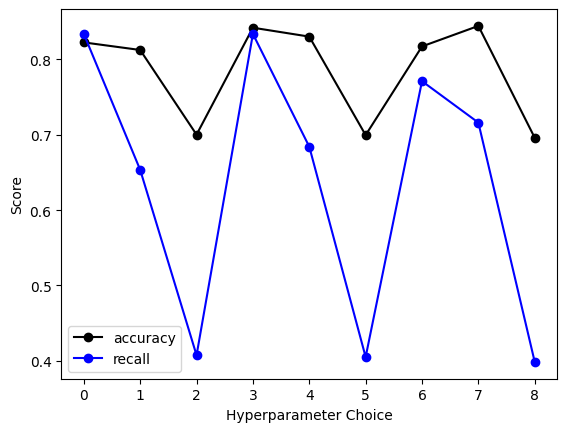

In [ ]:
### visualize the recall and accuracy scores for the different hyperparameter choices
plt.plot(acc_scores, marker='o', color='black',label='accuracy')
plt.plot(rec_scores, marker='o', color='blue',label='recall')
plt.xlabel('Hyperparameter Choice')
plt.ylabel('Score')
plt.legend()
print("Max Accuracy (black):", round(max(acc_scores), 4))
print("Max Recall (blue):", round(max(rec_scores), 4))

Which choice of hyperparameters should we pick? Choosing the right hyperparameters for this model requires revisiting which metrics are most important to our question. For this problem, we want to maximize both recall and accuracy.

Let's go with the parameters corresponding to x=0 (Looks good for both accuracy and recall!) but try other hyperparameters too (if you have time)

In [ ]:
forest = RandomForestClassifier(n_estimators=10, max_depth=2);
forest.fit(x_train_bal, y_train_bal);

Accuracy: 0.7756
Recall: 0.7043


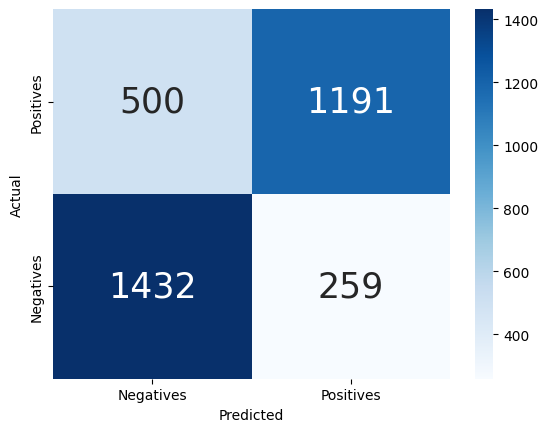

In [ ]:
## 3. Assess the Random Forest's performance using testing data
##Once again, we will use our testing data to make an initial evaluation of how the model is doing.

pred_test= forest.predict(x_test_bal)

# Call functions defined above to calculate metrics & plot a confusion matrix based on
# how well model simulates testing data
forest_acc, forest_rec = bin_metrics(y_test_bal, pred_test)
plot_cm(y_test_bal, pred_test)


In [ ]:
## 4. Check to see if the Random Forest is overfitting (or underfitting)
#Remember:
#testing metrics > training metrics = underfitting, model is too simple
#testing metrics < training metrics = overfitting, model is too complex

# Compare testing data metrics to data training metrics.
print("Training metrics:")
rf_pred_train= forest.predict(x_train_bal) 
bin_metrics(y_train_bal,rf_pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, pred_test);

Training metrics:
Accuracy: 0.7919
Recall: 0.7364
 
Testing metrics:
Accuracy: 0.7756
Recall: 0.7043


WOW - the random forest model was not an improvement over the logistical regression model.

Random forests seldom overfit, but if they do, one should try increasing the number of trees, or decreasing the amount of data used to construct each tree. See scikit-learn's Random Forest Classifier webpage (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for information on more hyperparameters one can tune to address overfitting.

In [ ]:
##5. Make a prediction with the Random Forest

# prediction output is in the format [probability no rain, probability rain]
forest_prediction = forest.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The meteorological conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(forest_prediction, digits=2))

The meteorological conditions are: 
day             2016-04-16
hour              0.916667
temp_F                32.2
RH                    87.5
dewtemp_F             28.9
wind_mph              14.1
wind_dir               333
windgust              21.7
windgust_dir           318
pres_Hg             845.66
SOLIN_Wm2              0.0
Prec_inches           0.07
prec_occur               1
Name: 2566, dtype: object
 
There is a 82.59% chance of precipitation given those meteorological conditions.


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Model 3: Support Vector Machines (SVMs)

SVMs divide observations into classes based on maximizing the distance between a "kernel" (basically a dividing function) and the elements of each feature/class/variable on a plane. Because the relationships between atmospheric variables and precipitation are inherently non-linear, we will choose a non-linear, "RBF" kernel.

In [ ]:
from sklearn import svm

In [ ]:
## 1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=False)

Choosing hyperparameters
In the case of SVMs, we can tune "C", the regularization parameter. Regularization) penalizes higher-order coefficients during training (i.e., Gradient Descent). Regularization is a way to reduce a model's complexity and address overfitting.

In SVMs, the lower the regularization parameter C, the higher the penalty. We are unsure what the C value should be. Thus, we train the model three times, each with a different value of C to see what the best value should be. I highly suggest learning more on regularization if you choose to pursue ML methods on your own.

In [ ]:
## 2. Train (and tune) the SVM (Note: this cell takes ~1 minute to run)

acc_scores = []
rec_scores = []

C_range = [0.01, 1, 100]
for i in C_range:
    start = time.time()
    print("C is... "+str(i))
    svmclassifier = svm.SVC(C=i, kernel='rbf', gamma='scale', max_iter=20000, probability=True)
    svmclassifier.fit(x_train_bal, y_train_bal)
    
    # Save model metrics in order to choose best hyperparameter
    pred_test= svmclassifier.predict(x_test_bal)
    acc_val = metrics.accuracy_score(y_test_bal, pred_test)
    acc_scores.append(acc_val)
    rec_val = metrics.recall_score(y_test_bal, pred_test)
    rec_scores.append(rec_val)

    end = time.time()
    print("Took "+str(end-start)+" seconds to train.")

C is... 0.01
Took 45.29145669937134 seconds to train.
C is... 1
Took 21.598001956939697 seconds to train.
C is... 100


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Took 21.652179718017578 seconds to train.


Max Accuracy (black): 0.8955
Max Recall (blue): 0.9126


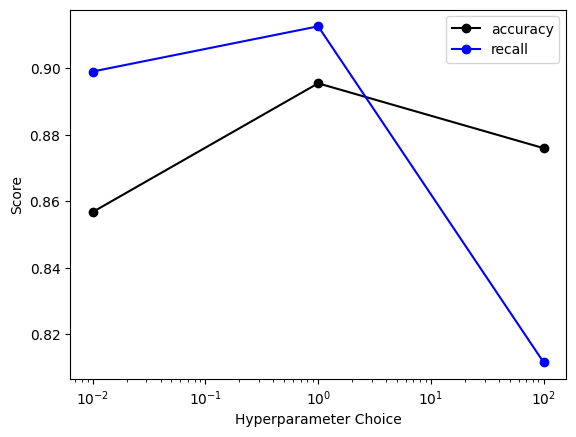

In [ ]:
plt.plot(C_range, acc_scores, marker='o', color='black',label='accuracy')
plt.plot(C_range, rec_scores, marker='o', color='blue',label='recall')
plt.xlabel('Hyperparameter Choice')
plt.xscale('log')
plt.ylabel('Score')
plt.legend()

print("Max Accuracy (black):", round(max(acc_scores), 4))
print("Max Recall (blue):", round(max(rec_scores), 4))

The SVM with C=1, i.e., a medium weight penalty, results in a balance among accuracy, precision, and recall.
We will train our final model with this hyperparameter.

In [ ]:
# Define SVM classifier & fit to training data
svmclassifier = svm.SVC(C=1, kernel='rbf', gamma='scale', max_iter=20000, probability=True)
svmclassifier.fit(x_train_bal, y_train_bal);

Accuracy: 0.8955
Recall: 0.9126


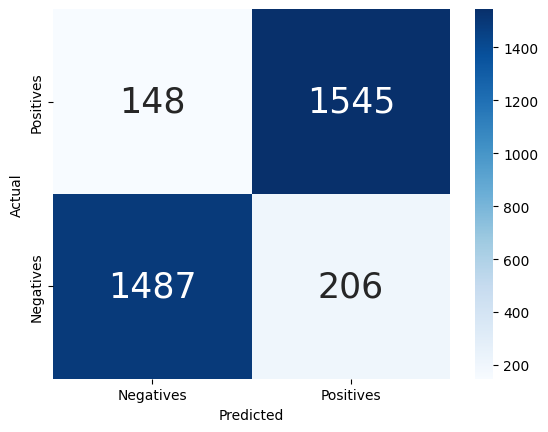

In [ ]:
## 3. Assess SVM performance using testing data

pred_test= svmclassifier.predict(x_test_bal)

# Call functions defined above to calculate metrics & plot a confusion matrix based on
# how well model simulates testing data
svm_acc, svm_rec = bin_metrics(y_test_bal, pred_test)
plot_cm(y_test_bal, pred_test)

WOW: using a non-linear Singular Vector Machine instead of a Logistic Regressor increased the recall and accuracy. 

In [ ]:

## 4. Check to see if the SVM is overfitting (or underfitting)
#Remember:
#testing metrics > training metrics = underfitting, model is too simple
#testing metrics < training metrics = overfitting, model is too complex

# Compare testing data metrics to data training metrics.
print("Training metrics:")
svm_pred_train= svmclassifier.predict(x_train_bal) 
bin_metrics(y_train_bal,svm_pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, pred_test);

Training metrics:
Accuracy: 0.9173
Recall: 0.9533
 
Testing metrics:
Accuracy: 0.8955
Recall: 0.9126


One can address overfitting in an SVM by changing the kernel to a simpler kernel, or tuning the regularization parameter C.

In [ ]:
## 5. Make a prediction with the SVM

# prediction output is in the format [probability no rain, probability rain]
svm_prediction = svmclassifier.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The meteorological conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(svm_prediction, digits=2))

The meteorological conditions are: 
day             2016-04-16
hour              0.916667
temp_F                32.2
RH                    87.5
dewtemp_F             28.9
wind_mph              14.1
wind_dir               333
windgust              21.7
windgust_dir           318
pres_Hg             845.66
SOLIN_Wm2              0.0
Prec_inches           0.07
prec_occur               1
Name: 2566, dtype: object
 
There is a 99.58% chance of precipitation given those meteorological conditions.


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


## Model 4: Neural Network

Note: there is a TON of information online about Neural Networks. Eleanor Recommends:
1) This three-part series of youtube videos (totaling about an hour in length) https://www.youtube.com/watch?v=aircAruvnKk. 

2) machinelearningmastery.com In fact, the model below is based off of this blog post (https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/)

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
## 1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=False)


In [ ]:
## 2. Train (and build and compile) the Neural Network
## There are lots of hyperparameters here. Please read the comments to guide you in playing with them later!

In [ ]:
### Build a very simple Neural Network and Compile
number_inputs = len(x_train_bal.columns)

# create model
nn = Sequential()
nn.add(Dense(number_inputs, input_dim=number_inputs, activation='relu'))

# Try uncommenting this to address overfitting
# from keras.regularizers import l2
# reg = l2(0.001)
# nn.add(Dense(number_inputs, activation='relu',bias_regularizer=reg,activity_regularizer=reg))

# try commenting out one and then the other
nn.add(Dense(1, activation='sigmoid'))
#nn.addDense(1, activation='softmax'))

# Compile model 
# Also try changing the learning rate.
learning_rate = 0.001 # only used in the SGD optimizer.

# Also try commenting out one & then the other. 
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
#nn.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=learning_rate), metrics=['accuracy']) 

In [ ]:
### Actually training the model

batch_size = 24 # The number of samples the network sees before it backpropagates (batch size) # 24 & 32 yield accuracy = 87%
epochs = 100 # The number of times the network will loop through the entire dataset (epochs)
shuffle = True # Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 # Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

# Train the neural network!
start = time.time()

history = nn.fit(x_train_bal, y_train_bal, validation_data=(x_test_bal, y_test_bal), 
          batch_size=batch_size, epochs=epochs, shuffle=shuffle, verbose=verbose)

end = time.time()
print("Neural Network took "+str(end-start)+" seconds to train.")

Epoch 1/100
567/567 - 3s - loss: 0.6122 - accuracy: 0.6810 - val_loss: 0.5248 - val_accuracy: 0.7713 - 3s/epoch - 4ms/step
Epoch 2/100
567/567 - 2s - loss: 0.5034 - accuracy: 0.7790 - val_loss: 0.4387 - val_accuracy: 0.8093 - 2s/epoch - 3ms/step
Epoch 3/100
567/567 - 2s - loss: 0.4569 - accuracy: 0.8017 - val_loss: 0.4031 - val_accuracy: 0.8137 - 2s/epoch - 4ms/step
Epoch 4/100
567/567 - 2s - loss: 0.4352 - accuracy: 0.8140 - val_loss: 0.3875 - val_accuracy: 0.8340 - 2s/epoch - 3ms/step
Epoch 5/100
567/567 - 1s - loss: 0.4221 - accuracy: 0.8220 - val_loss: 0.3772 - val_accuracy: 0.8387 - 1s/epoch - 3ms/step
Epoch 6/100
567/567 - 1s - loss: 0.4131 - accuracy: 0.8231 - val_loss: 0.3692 - val_accuracy: 0.8393 - 1s/epoch - 2ms/step
Epoch 7/100
567/567 - 1s - loss: 0.4061 - accuracy: 0.8289 - val_loss: 0.3652 - val_accuracy: 0.8437 - 1s/epoch - 2ms/step
Epoch 8/100
567/567 - 1s - loss: 0.4002 - accuracy: 0.8325 - val_loss: 0.3596 - val_accuracy: 0.8470 - 945ms/epoch - 2ms/step
Epoch 9/100
5

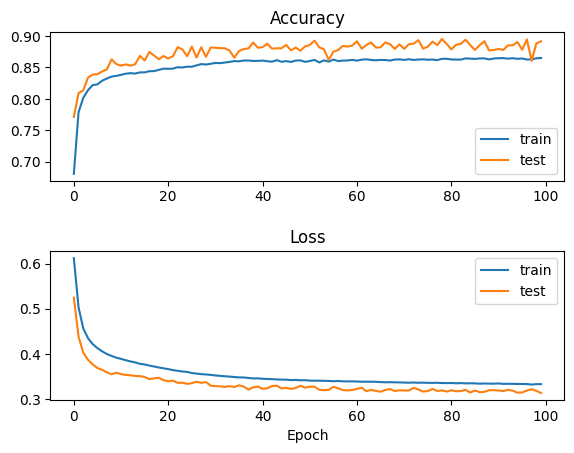

In [ ]:
#Accuracy & loss with epochs
#Neural networks train in epochs. During each epoch, the model trains by sweeping over each layer, 
#adjusting weights based on their resulting errors, through processes called forward propagation and backpropagation. 
#By plotting the model accuracy & loss which each epoch, we can visualize how the model error evolves with training.

figure, axes = plt.subplots(nrows=2,ncols=1)
figure.tight_layout(pad=3.0)

# plot accuracy during training
plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend();

# plot loss during training
plt.subplot(212)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch");
plt.legend()
plt.show();

107/107 [==============================] - 0s 1ms/step
Accuracy: 0.8917
Recall: 0.9041


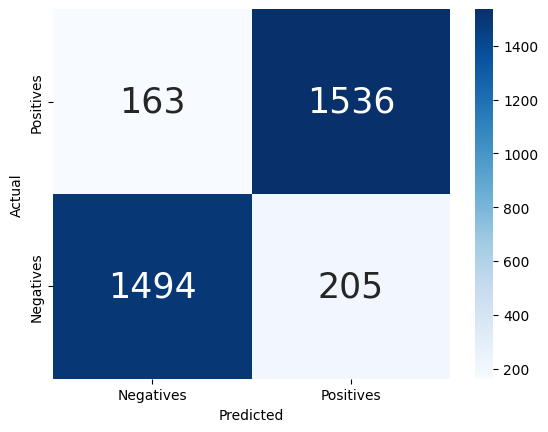

In [ ]:
##3. Assess Neural Network's performance using testing data
## Though the accuracy is pictured above, additionally quantify recall on testing data with the 
## same functions used previously to remain consistent

pred_test= (nn.predict(x_test_bal)>0.5).astype("int32")
nn_acc, nn_rec = bin_metrics(y_test_bal, pred_test)
plot_cm(y_test_bal, pred_test)

In [ ]:
## 4. Check to see if the Neural Network is overfitting (or underfitting)
#Remember:
#testing metrics > training metrics = underfitting, model is too simple
#testing metrics < training metrics = overfitting, model is too complex

#Note: Neural networks can easily overfit because they are complex and can fit to the training data extremely well, 
# Overfitting prevents neural networks from generalizing to other data (like the testing data).

# Compare testing data metrics to data training metrics.
print("Training metrics:")
nn_pred_train= (nn.predict(x_train_bal)>0.5).astype("int32")
bin_metrics(y_train_bal,nn_pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, pred_test);

Training metrics:
426/426 [==============================] - 1s 2ms/step
Accuracy: 0.8672
Recall: 0.8762
 
Testing metrics:
Accuracy: 0.8917
Recall: 0.9041


In [ ]:
## 5. Make a prediction with the Neural Network

# prediction output is in the format [probability no rain, probability rain]
nn_prediction = nn.predict(np.array(testpredictor).reshape(1, -1))[0][0]*100
print("The meteorological conditions are: ")
print(origvals)
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(nn_prediction, digits=2))


1/1 [==============================] - 0s 106ms/step
The meteorological conditions are: 
day             2016-04-16
hour              0.916667
temp_F                32.2
RH                    87.5
dewtemp_F             28.9
wind_mph              14.1
wind_dir               333
windgust              21.7
windgust_dir           318
pres_Hg             845.66
SOLIN_Wm2              0.0
Prec_inches           0.07
prec_occur               1
Name: 2566, dtype: object
There is a 99.45% chance of precipitation given those meteorological conditions.


## SUMMARY: Compare all Four Machine Learning Models

In [ ]:
model_metrics = pd.DataFrame({'Metrics':['Accuracy','Recall','Prediction example'],
     'Logistic Regression':[lr_acc, lr_rec, lr_prediction],
    'Random Forest':[forest_acc, forest_rec, forest_prediction],
    'Singular Vector Machine':[svm_acc, svm_rec, svm_prediction],
    'Neural Network':[nn_acc, nn_rec, nn_prediction]})
model_metrics = model_metrics.set_index('Metrics')
model_metrics

,Logistic Regression,Random Forest,Singular Vector Machine,Neural Network
Metrics,,,,
Accuracy,0.825029,0.775577,0.895452,0.891701
Recall,0.851114,0.704317,0.912581,0.904061
Prediction example,95.425174,82.585488,99.577246,99.453008


## STEP 4: Assess Feature Importance

Note: Feature Importance is not possible with non-linear Singular Vector Machines because the data is transformed by the kernel into another space that is unrelated to the input space.

In [ ]:
## Feature importance in Logistical Regression Model

pd.DataFrame(abs(lr.coef_[0]),
             index = x.columns,
             columns=['importance']).sort_values('importance',ascending=False)

,importance
RH,9.691046
windgust,8.694310
temp_F,3.403126
SOLIN_Wm2,1.830624
pres_Hg,1.004512
wind_mph,0.331343
wind_dir,0.269251
dewtemp_F,0.145528
windgust_dir,0.089092


In [ ]:
## Feature importance in Random Forest Model

pd.DataFrame(forest.feature_importances_,
                                   index = x.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

,importance
RH,0.510672
dewtemp_F,0.196140
temp_F,0.115350
wind_mph,0.071002
windgust,0.055271
SOLIN_Wm2,0.045692
windgust_dir,0.005874
wind_dir,0.000000
pres_Hg,0.000000


In [ ]:
## Feature importance in Neural Network

cols = x.columns.values
nn_featimportance = []
for var in cols:
    # create a vector corresponding to a 1 where the feature is located:
    inputvector = np.array((cols==var).astype(int).reshape(1, -1))
    nn_featimportance.append(nn.predict(inputvector)[0][0]*100)

pd.DataFrame( nn_featimportance,
             index = x.columns,
             columns=['importance']).sort_values('importance',ascending=False)    

1/1 [==============================] - 0s 38ms/step


,importance
SOLIN_Wm2,99.656641
RH,97.785914
windgust,95.858526
wind_mph,63.513589
windgust_dir,59.529984
pres_Hg,23.419379
dewtemp_F,9.876572
wind_dir,1.439871
temp_F,0.616646
